In [ ]:
#| default_exp eval

In [ ]:
#| export
import logging as l

import torch

from looped_experiments.all import *

In [ ]:
#| export
class MetricsCB(Callback):
    def __init__(self, metric_fn): self.metric_fn = metric_fn
    def before_fit(self, _): self.metrics = []

    def after_batch(self, learn):
        self.metrics.append(to_cpu(self.metric_fn(learn.preds, learn.yb)))

    def after_epoch(self, learn):
        try:
            self.metrics = torch.cat(self.metrics)
        except TypeError:
            l.warning("Was not able to concatenate metrics")
            pass

In [ ]:
#| export
def squared_error(preds, ys):
    return (preds - ys).square()

In [ ]:
#| export
def eval(cfg, model_path=None):
    train = cfg.training
    task = get_task_cls(cfg.task.task_name)(train.batch_size, **cfg.task)
    dl_eval = dataloader(task, train.eval_steps)

    @FnCallback("before_batch")
    def trans_input(learner): learner.xb = (learner.xb, learner.yb)

    model = get_model(cfg.model)
    weights = torch.load(model_path or cfg.out_dir / "model_last.pt", weights_only=True)
    model.load_state_dict(weights)
    loss_fn = get_loss(cfg.model)
    metric_cb = MetricsCB(squared_error)
    cbs = [ToDeviceCB(), trans_input, metric_cb]
    Learner(model, None, dl_eval, None, loss_fn=loss_fn, cbs=cbs).eval()
    return metric_cb.metrics

In [ ]:
eval_overrides = ["training.batch_size=256", "training.eval_steps=10", "task.n_points=41"]

In [ ]:
errs = {}

In [ ]:
cfg = get_config(overrides=eval_overrides + ["model=loop"])
errs['loop'] = eval(cfg, '../results/linear_regression/gpt2_loop/model_last.pt')

In [ ]:
cfg = get_config(overrides=eval_overrides+["model.n_layer=6"])
errs["transformer"] = eval(cfg, '../results/linear_regression/gpt2/2024-08-01_14-22-16/model_last.pt')

In [ ]:
#| export
def aggregate_metrics(result_dict, non_truncated_dims, bootstrap_trials=1000):
    """
    Takes as input a tensor of shape (num_eval, n_points) and returns a dict with
    per-point mean, stddev, and bootstrap limits
    """
    d = non_truncated_dims
    results = {}
    for model_name in result_dict.keys():
        errs = result_dict[model_name]
        tmp = {}
        tmp["mean"] = errs.mean(0) / d
        tmp["std"] = errs.std(0, unbiased=True) / d
        n = len(errs)
        bootstrap_indices = torch.randint(n, size=(bootstrap_trials, n))
        bootstrap_means = errs[bootstrap_indices].mean(dim=1).sort(dim=0)[0]
        tmp["bootstrap_low"] = bootstrap_means[int(0.05 * bootstrap_trials), :] / d
        tmp["bootstrap_high"] = bootstrap_means[int(0.95 * bootstrap_trials), :] / d
        results[model_name] = tmp

    return results

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

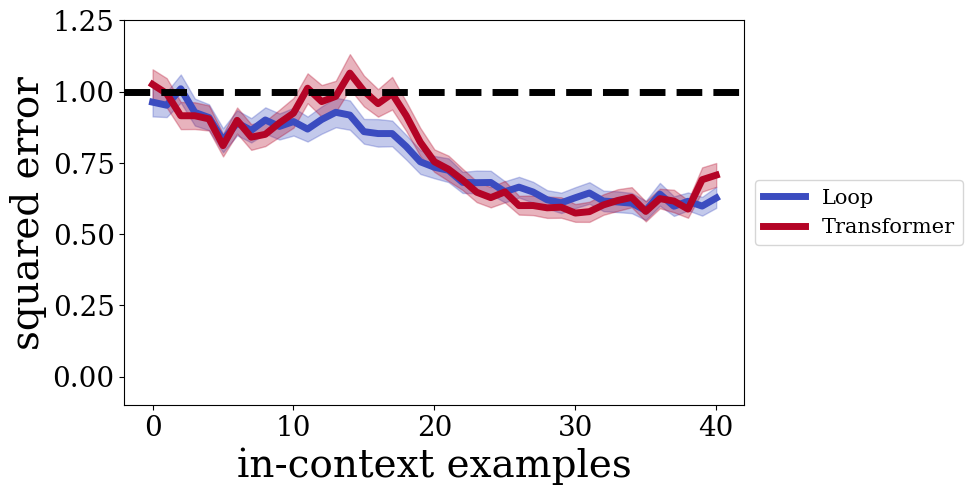

In [ ]:

fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
            'size': fig_hparam['fontsize'],
            }

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = res

cmap = plt.get_cmap("coolwarm")
# result_name_list = ['Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging', 'Looped Transformer']
result_name_list = errs.keys()
colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=model_name.capitalize())
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
ax.set_ylim(-0.1, 1.25)
# plt.xticks(np.arange(0, n_points))
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])

# plt.savefig("result_folder/Figures/LR_err.pdf", format='pdf', dpi=600, bbox_inches='tight')